In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data(file_path):
    """Load the Online Retail Dataset."""
    return pd.read_excel(file_path)

In [3]:
df = load_data('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
print(f"Shape: {df.shape}")

Shape: (541909, 8)


In [5]:
def preprocess_data(df):
    """Handle missing values, convert date, and remove cancelled orders."""
    df.dropna(inplace=True)
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    return df[~df['InvoiceNo'].astype(str).str.contains('C')]


df_cleaned = preprocess_data(df)
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
print(f"Shape: {df_cleaned.shape}")

Shape: (397924, 8)


In [7]:
def engineer_features(df):
    """Calculate RFM (Recency, Frequency, Monetary) features."""
    df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
    customer_features = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
        'InvoiceNo': 'count',
        'TotalAmount': 'sum'
    })
    customer_features.columns = ['Recency', 'Frequency', 'Monetary']
    return customer_features


customer_features = engineer_features(df_cleaned)
customer_features.head()

C:\Users\elhas\AppData\Local\Temp\ipykernel_25384\2653248100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


In [8]:
print(f"Shape: {customer_features.shape}")

Shape: (4339, 3)


In [9]:
def apply_pca(data, n_components=2):
    """Apply PCA for dimensionality reduction."""
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data_scaled)
    return pca_result, pca


pca_result, pca = apply_pca(customer_features)
print(f"PCA shape: {pca_result.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

PCA shape: (4339, 2)
Explained variance ratio: [0.50848039 0.30213617]


C:\Users\elhas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\elhas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\elhas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\elhas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

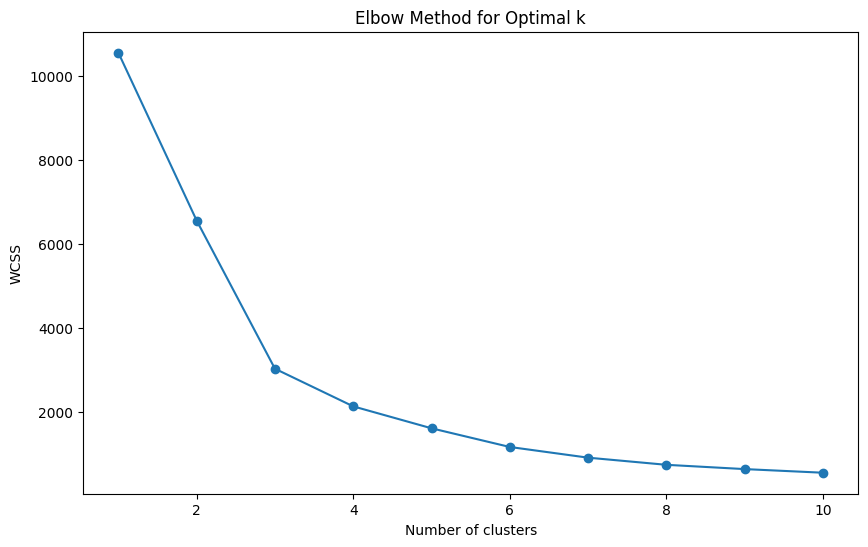

In [10]:
def find_optimal_clusters(data, max_k):
    """Use the elbow method to find the optimal number of clusters."""
    wcss = [KMeans(n_clusters=k, init='k-means++', random_state=42).fit(data).inertia_
            for k in range(1, max_k+1)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k+1), wcss, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()


find_optimal_clusters(pca_result, 10)

In [11]:
def perform_kmeans(data, n_clusters):
    """Perform K-means clustering."""
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
    return kmeans.fit_predict(data)

In [12]:
n_clusters = 4  # Assuming 4 clusters from elbow method
cluster_labels = perform_kmeans(pca_result, n_clusters)
print(f"Number of clusters: {n_clusters}")
print(f"Cluster labels shape: {cluster_labels.shape}")

Number of clusters: 4
Cluster labels shape: (4339,)


In [13]:
def profile_clusters(data, labels):
    """Profile the clusters based on mean values of features."""
    data['Cluster'] = labels
    return data.groupby('Cluster').mean()


cluster_profile = profile_clusters(customer_features, cluster_labels)
print(cluster_profile)

            Recency    Frequency       Monetary
Cluster                                        
0         43.130049    75.245649    1337.215400
1        248.350379    27.412879     488.420143
2          4.000000  2779.727273  135422.710909
3         15.264317   481.392070   12485.310661


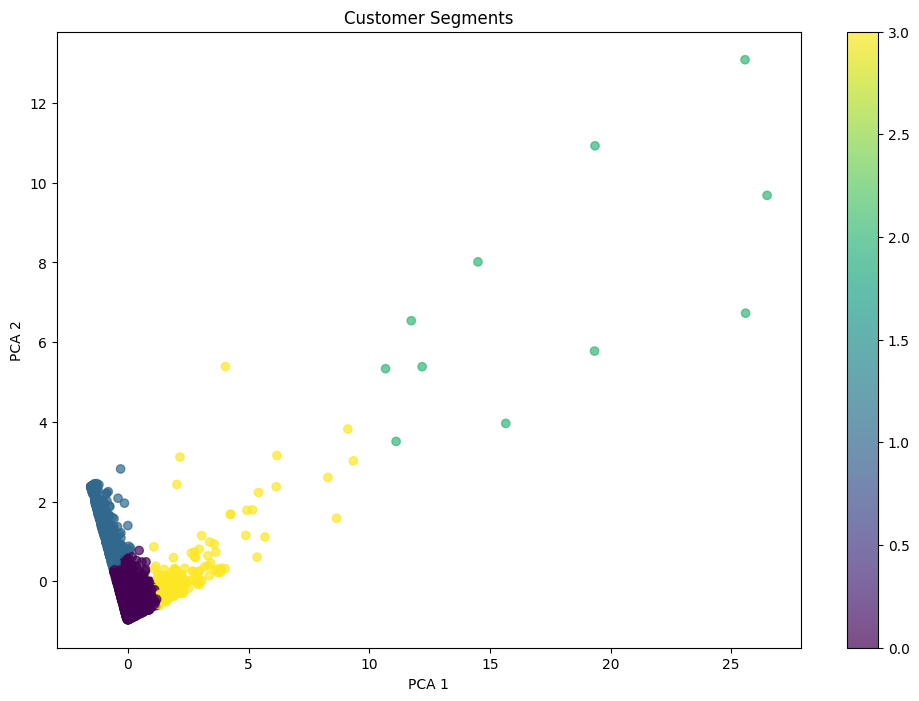

In [14]:
def visualize_clusters(data, labels):
    """Visualize the clusters using a scatter plot."""
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title('Customer Segments')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.colorbar(scatter)
    plt.show()


visualize_clusters(pca_result, cluster_labels)

In [15]:
def evaluate_clustering(data, labels):
    """Evaluate the clustering using silhouette score."""
    silhouette_avg = silhouette_score(data, labels)
    print(f"The average silhouette score is: {silhouette_avg:.2f}")
    return silhouette_avg


silhouette_avg = evaluate_clustering(pca_result, cluster_labels)

The average silhouette score is: 0.63


In [16]:
def personalize_recommendations(cluster_profile):
    """Generate personalized recommendations based on cluster profiles."""
    recommendations = {}
    overall_mean = cluster_profile.mean()
    overall_std = cluster_profile.std()
    
    print("\nDetailed Cluster Analysis:")
    print(f"Overall Mean: {overall_mean}")
    print(f"Overall Std Dev: {overall_std}")
    
    for cluster, profile in cluster_profile.iterrows():
        print(f"\nCluster {cluster}:")
        print(f"Profile: {profile}")
        print(f"Monetary vs Mean: {profile['Monetary']} vs {overall_mean['Monetary']}")
        print(f"Frequency vs Mean: {profile['Frequency']} vs {overall_mean['Frequency']}")
        print(f"Recency vs Mean: {profile['Recency']} vs {overall_mean['Recency']}")
        
        if (profile['Monetary'] > overall_mean['Monetary'] + overall_std['Monetary'] and 
            profile['Frequency'] > overall_mean['Frequency'] + overall_std['Frequency']):
            recommendations[cluster] = "High-value, frequent customers. Focus on retention, premium products, and exclusive offers."
        elif (profile['Monetary'] > overall_mean['Monetary'] + overall_std['Monetary'] and 
              profile['Recency'] < overall_mean['Recency']):
            recommendations[cluster] = "High-value, recent customers. Encourage continued engagement with personalized recommendations."
        elif (profile['Frequency'] > overall_mean['Frequency'] and 
              profile['Recency'] < overall_mean['Recency']):
            recommendations[cluster] = "Frequent, recent buyers. Offer loyalty programs and cross-sell opportunities."
        elif profile['Recency'] > overall_mean['Recency'] + overall_std['Recency']:
            recommendations[cluster] = "Less recent customers. Re-engagement campaign needed with special comeback offers."
        else:
            recommendations[cluster] = "Average customers. Enhance engagement with targeted promotions and product recommendations."
        
        print(f"Recommendation: {recommendations[cluster]}")
    
    return recommendations


print("\n--- Testing personalize_recommendations ---")
recommendations = personalize_recommendations(cluster_profile)


--- Testing personalize_recommendations ---

Detailed Cluster Analysis:
Overall Mean: Recency         77.686186
Frequency      840.944468
Monetary     37433.414278
dtype: float64
Overall Std Dev: Recency        114.958742
Frequency     1308.470484
Monetary     65554.502244
dtype: float64

Cluster 0:
Profile: Recency        43.130049
Frequency      75.245649
Monetary     1337.215400
Name: 0, dtype: float64
Monetary vs Mean: 1337.2154 vs 37433.41427821907
Frequency vs Mean: 75.24564860426929 vs 840.9444676510005
Recency vs Mean: 43.13004926108374 vs 77.6861863073948
Recommendation: Average customers. Enhance engagement with targeted promotions and product recommendations.

Cluster 1:
Profile: Recency      248.350379
Frequency     27.412879
Monetary     488.420143
Name: 1, dtype: float64
Monetary vs Mean: 488.42014299242425 vs 37433.41427821907
Frequency vs Mean: 27.41287878787879 vs 840.9444676510005
Recency vs Mean: 248.35037878787878 vs 77.6861863073948
Recommendation: Less recent cus